In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [3]:
conditions = ["Original",
              'chatgpt',
              'sentenceshuffle_passage',
              'sentenceshuffle_topic',
              'sentenceshuffle_random']

In [4]:
model_identifier = 'gpt2-xl'
emb_context = 'Passage'

In [5]:
def get_layers(model_identifier, final_only=False):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind, filename in enumerate(os.listdir(working_dir)):
        if f"identifier={model_identifier}" in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            
            if final_only:
                final_layer = layers[-1]
                return final_layer
            else:
                return layers

In [6]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [7]:
def get_dictionary(model_identifier,layer_identifier=None, emb_context="Passage"):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_layers(model_identifier, final_only=True)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        if not f"emb_context={emb_context}" in filename:
            continue
        if not model_identifier in filename:
            continue
        if (any(f'{x}-lasttoken' in filename for x in conditions)):
            passage_identifier = get_passage_identifier(filename)

            condition = filename.split("Pereira2018-")[1]
            condition = condition.split("-lasttoken")[0]

            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}].data

            if not condition in model_dictionary:
                model_dictionary[condition] = {}
            model_dictionary[condition][passage_identifier] = data
    
    return model_dictionary

In [8]:
model_dictionary = get_dictionary(model_identifier=model_identifier, emb_context=emb_context)

/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


This is the layer I'm looking at:  encoder.h.47


  0%|          | 0/65334 [00:00<?, ?it/s]

In [9]:
from scipy import spatial
import pandas as pd

conds = []
cosines = []
for cond in [x for x in conditions if x != 'Original']:
    original_dict = model_dictionary['Original']
    cond_dict = model_dictionary[cond]

    for sent_id in original_dict.keys():
        for ind in range(len(original_dict[sent_id])):
            cos = 1 - spatial.distance.cosine(original_dict[sent_id][ind], cond_dict[sent_id][ind])
            cosines.append(cos)
            conds.append(cond)

cosine_df = pd.DataFrame({
    "condition" : conds,
    "cosine_similarity" : cosines
})

In [10]:
cosine_df['condition'] = cosine_df['condition'].replace(
        {'chatgpt' : 'Paraphrase',
         'sentenceshuffle_passage': 'RandSent\nFromPassage',
         'sentenceshuffle_topic': 'RandSent\nFromTopic',
         'sentenceshuffle_random': 'RandSent'})

In [11]:
cosine_df.head()

,condition,cosine_similarity
0,Paraphrase,0.960791
1,Paraphrase,0.936067
2,Paraphrase,0.950616
3,Paraphrase,0.964149
4,Paraphrase,0.915003


#### Plot 

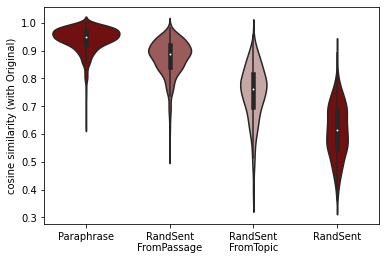

In [12]:
ax = sns.violinplot(data=cosine_df, x="condition", y="cosine_similarity", palette = sns.light_palette("maroon", 4, reverse=True)[:3])
ax.set(xlabel='', ylabel='cosine similarity (with Original)')
# conditions = ["RandSentFromPassage", "RandSentFromTopic", "RandSent"]
# positions = list(range(len(conditions)))
# ax.set_xticks(positions)
# xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
# ax.set_xticklabels([x for x in xticknames if x], rotation=70, ha="right", rotation_mode="anchor")

plt.show()

#### Distribution stats

                          Paraphrase  RandSent\nFromPassage  \
Paraphrase              1.000000e+00           3.330236e-86   
RandSent\nFromPassage   3.330236e-86           1.000000e+00   
RandSent\nFromTopic    1.212125e-254          1.789089e-122   
RandSent                0.000000e+00           0.000000e+00   

                       RandSent\nFromTopic       RandSent  
Paraphrase                   1.212125e-254   0.000000e+00  
RandSent\nFromPassage        1.789089e-122   0.000000e+00  
RandSent\nFromTopic           1.000000e+00  6.992878e-109  
RandSent                     6.992878e-109   1.000000e+00  


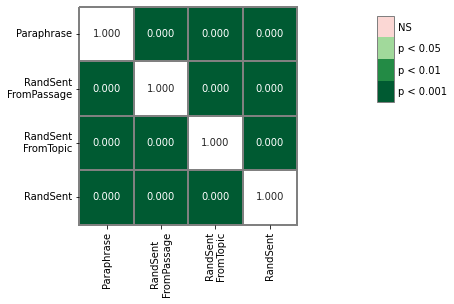

In [13]:
import scikit_posthocs as sp

heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

ttest = sp.posthoc_ttest(cosine_df, val_col='cosine_similarity', group_col='condition', p_adjust='bonferroni')
print(ttest)

ax2 = sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
plt.show()

# Merge figures

In [14]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }

sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(121)
sns.violinplot(data=cosine_df, x="condition", y="cosine_similarity", palette = sns.light_palette("maroon", 5, reverse=True)[:4])
ax.set(xlabel='', ylabel='cosine similarity (with Original)')
ax.set_ylim([0, 1.05]) 

ax = fig.add_subplot(122)
sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)

plt.savefig('results_paper_revision/SupplementaryInformation/semantic-distance_repSimilarity.svg', dpi=180, bbox_inches="tight")
plt.savefig('results_paper_revision/SupplementaryInformation/semantic-distance_repSimilarity.png', dpi=180, bbox_inches="tight")
plt.show()
